In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
n = 120

In [3]:
# Reference set of bits
b = 8
m = int(n / b)
len_M = 60

H = ['00000000', '11111111', '11110000', '00001111', '00111100']
M = set()
while len(M) < len_M:
    x = list(np.random.choice(H, size=m, replace=True))
    target = ''
    for seq in x:
        target += seq
    M.add(target)

In [4]:
def edit_distance(sequence1, sequence2):
    assert len(sequence1) == len(sequence2) == n
    return (np.array(list(sequence1)) != np.array(list(sequence2))).sum()

def reward(sequence):
    reward = np.exp(-n)
    for mode in M:
        tmp = np.exp(- edit_distance(sequence, mode))
        if tmp > reward:
            reward = tmp
    return reward

In [5]:
rewards = []
for _ in range(10000):
    x = list(np.random.choice(['0', '1'], size=n, replace=True))
    target = ''
    for seq in x:
        target += seq
    rewards.append(reward(target))

(array([9.98e+03, 1.00e+01, 0.00e+00, 7.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 3.00e+00]),
 array([4.78089288e-25, 2.31952287e-17, 4.63904570e-17, 6.95856852e-17,
        9.27809135e-17, 1.15976142e-16, 1.39171370e-16, 1.62366598e-16,
        1.85561827e-16, 2.08757055e-16, 2.31952283e-16]),
 <BarContainer object of 10 artists>)

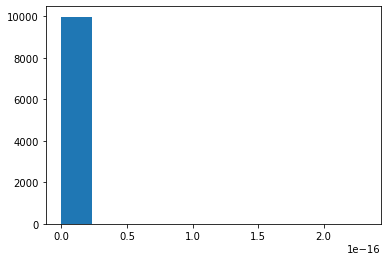

In [6]:
plt.hist(rewards)

In [7]:
max(rewards)

2.3195228302435696e-16

In [9]:
from models import make_mlp, Embedding, get_padding_masks, TransformerModel

In [12]:
make_mlp([2,3,4, 5])

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=4, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=4, out_features=5, bias=True)
)

In [15]:
import torch
import torch.nn as nn
import math


# Taken from the PyTorch Transformer tutorial
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [16]:
import math
import torch
import torch.nn as nn



class GFNTransformer(nn.Module):
    def __init__(self, num_tokens, num_outputs, num_hid,
                 num_layers, num_head, max_len=60, dropout=0.1):
        super().__init__()
        self.pos = PositionalEncoding(num_hid, dropout=dropout, max_len=max_len + 1)
        self.embedding = nn.Embedding(num_tokens, num_hid)
        encoder_layers = nn.TransformerEncoderLayer(num_hid, num_head, num_hid, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output = nn.Linear(num_hid, num_outputs)

    def forward(self, x, mask=None):
        u = x
        x = self.embedding(x)
        x = self.pos(x)
        x = self.encoder(x, src_key_padding_mask=mask)
        pooled_x = x[0, :] # This is weird... but this is what BERT calls pooling?
        # indeed doing e.g. this:
        #_mask = (1-mask.float())
        #pooled_x = (x * _mask.T.unsqueeze(2)).sum(0) / _mask.sum(1).unsqueeze(1)
        # seems to no be as good? (Well, the max reward is lower but loss is similar..)
        y = self.output(pooled_x)
        return y

In [142]:
transformer = GFNTransformer(num_tokens=2, num_outputs=1, dropout=0.,
                             num_hid=64, num_layers=3, num_head=8)

In [145]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=7e-4)
losses = []
for _ in range(3000):
    optimizer.zero_grad()
    length = n
    x = torch.randint(2, (length, 16)).to(torch.long)
    pred = transformer(x, None).squeeze()
    target = (x.sum(0) / 100. - x[10:x.shape[0] // 2:].sum(0) / 100. + x[:10, :].float().mean(0))
    loss = nn.MSELoss()(target, pred)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


RuntimeError: The size of tensor a (120) must match the size of tensor b (61) at non-singleton dimension 0

In [140]:
transformer(x, None).shape

torch.Size([120, 1])

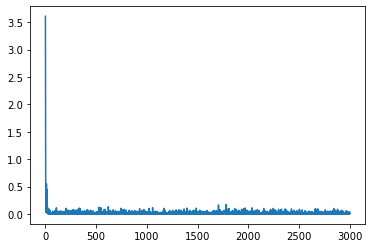

In [112]:
plt.plot(losses)

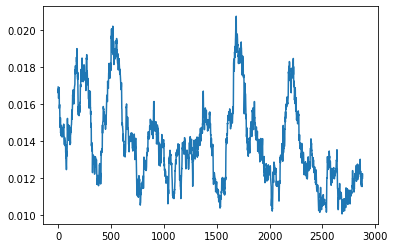

In [113]:
N = 100
plt.plot(np.convolve(losses[20:], np.ones(N) / N, mode='valid'))

In [122]:
length = 120
x = torch.randint(2, (1, length)).to(torch.long)
pred = transformer(x, None)[-1]
target = x.sum() / 100. - x[10:len(x) // 2].sum() / 100. + x[:10].float().mean()
print(pred.item(), target.item())

1.0846059322357178 1.0449999570846558


In [94]:
torch.mean(x.float()) + 1

tensor(1.5000)

In [95]:
x.sum() / 100. - x[10:len(x) // 2].sum() / 100. + x[:10].float().mean()

tensor(1.1000)

In [ ]:
torch.nn.Linear()